In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision as tv
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import hamming_loss, accuracy_score

import arff

# Loading in data

In [16]:
nus_train = arff.load(open('./nus/nus-wide-full-cVLADplus-train.arff'))
nus_test = arff.load(open('./nus/nus-wide-full-cVLADplus-test.arff'))

In [27]:
nus_train_x = np.array(nus_train['data'])[:, 1:129].astype('float64')
nus_train_y = np.array(nus_train['data'])[:, 129:].astype('float64')

nus_test_x = np.array(nus_test['data'])[:, 1:129].astype('float64')
nus_test_y = np.array(nus_test['data'])[:, 129:].astype('float64')

In [28]:
nus_train_x.shape, nus_train_y.shape, nus_test_x.shape, nus_test_y.shape

((161789, 128), (161789, 81), (107859, 128), (107859, 81))

### Data label attributes:

Cardinality

In [68]:
nus_train_y.sum(axis=1).mean(), nus_test_y.sum(axis=1).mean()

(1.8632848957592913, 1.876421995382861)

Classes are pretty un-uniformly distributed. So using Hamming Loss might not be the best.

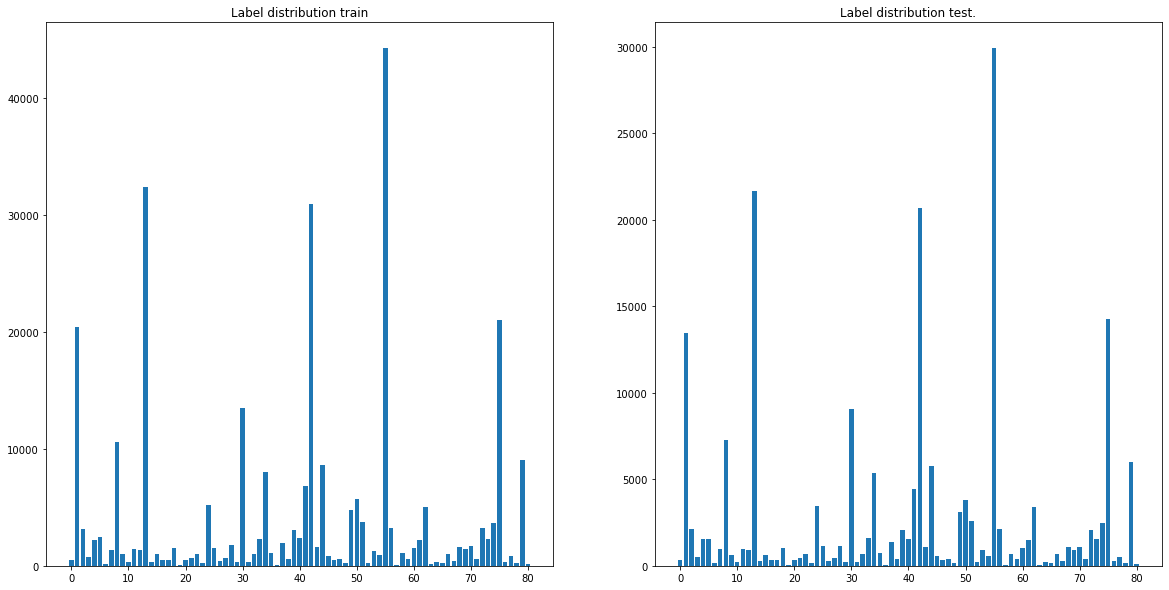

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].bar(range(len(nus_train_y.sum(axis=0))), nus_train_y.sum(axis=0))
axs[0].set_title("Label distribution train")

axs[1].bar(range(len(nus_test_y.sum(axis=0))), nus_test_y.sum(axis=0))
axs[1].set_title("Label distribution test.")
plt.show()

Normalized distributions between class are very similar

In [77]:
norm_train_dist = nus_train_y.sum(axis=0)/nus_train_y.sum(axis=0).sum()
norm_test_dist = nus_test_y.sum(axis=0)/nus_test_y.sum(axis=0).sum()
np.sum(norm_train_dist-norm_test_dist)

2.6020852139652106e-18

Making TensorDatasets

In [111]:
train_dataset = TensorDataset(torch.Tensor(nus_train_x), torch.Tensor(nus_train_y))
test_dataset = TensorDataset(torch.Tensor(nus_test_x), torch.Tensor(nus_test_y))

train_dataloader = DataLoader(train_dataset, batch_size=1028)
test_dataloader = DataLoader(test_dataset, batch_size=1028)

Simple FC Model.

In [126]:
class NusModel(torch.nn.Module):
    
    def __init__(self):
        super(NusModel, self).__init__()
        self.fc1 = torch.nn.Linear(128, 100)
        self.fc2 = torch.nn.Linear(100, 81)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Training Setup, and Loop

In [128]:
num_epochs = 200
lr = 0.1

device = torch.device('cuda')

net = NusModel().to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
writer = SummaryWriter()

train_loss = []
test_loss = []

for epoch in range(num_epochs+1):
    
    # Training.
    net.train()
    loss_tracker = 0.0
    for x, y in train_dataloader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        preds = net(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        loss_tracker+=loss.item()
    writer.add_scalar('loss/train', loss_tracker/len(train_dataset), epoch)
    train_loss.append(loss_tracker/len(train_dataset))
    
    # Evaluation
    net.eval()
    test_tracker = 0.0
    for x, y in test_dataloader:
        x, y = x.cuda(), y.cuda()
        preds = net(x)
        loss = criterion(preds, y)
        test_tracker += loss.item()
    writer.add_scalar('loss/test', test_tracker/len(test_dataset), epoch)
    test_loss.append(test_tracker/len(test_dataset))
    
    if epoch % 5 == 0:
        print("Epoch: {}, Train loss: {}, Test loss: {}".format(epoch, train_loss[-1], test_loss[-1]))

Epoch: 0, Train loss: 0.0006517729013171832, Test loss: 0.000621299202022026
Epoch: 5, Train loss: 0.00013319374597805958, Test loss: 0.00011856016299203328
Epoch: 10, Train loss: 8.864674828240395e-05, Test loss: 8.79245820080087e-05
Epoch: 15, Train loss: 8.463957154452927e-05, Test loss: 8.45694191033598e-05
Epoch: 20, Train loss: 8.355871539043874e-05, Test loss: 8.361094976959361e-05
Epoch: 25, Train loss: 8.311404961351007e-05, Test loss: 8.3205364439714e-05
Epoch: 30, Train loss: 8.288159743028299e-05, Test loss: 8.298928022952733e-05
Epoch: 35, Train loss: 8.2738969438259e-05, Test loss: 8.285472236678624e-05
Epoch: 40, Train loss: 8.264069190117521e-05, Test loss: 8.276087450571542e-05
Epoch: 45, Train loss: 8.256674283141255e-05, Test loss: 8.268955297865722e-05
Epoch: 50, Train loss: 8.250716183393788e-05, Test loss: 8.263162870198834e-05
Epoch: 55, Train loss: 8.245651470378381e-05, Test loss: 8.258207922219039e-05
Epoch: 60, Train loss: 8.241159298347758e-05, Test loss: 8.

In [129]:
writer.add_graph(net, input_to_model=train_dataset[:20][0].cuda())

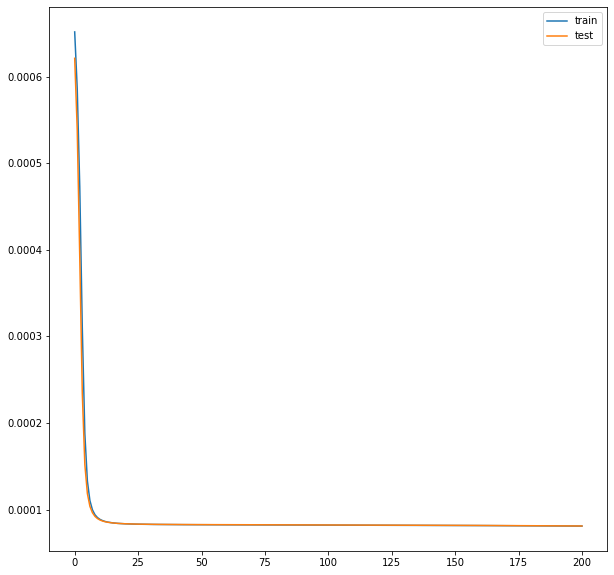

In [130]:
plt.figure(figsize=(10,10))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()

# Save the model after training.

In [131]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
def load_model(model_cls, path):
    model = model_cls(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    model.eval()

In [132]:
save_model(net, './models/mod_nus_v1.torch')

In [133]:
def eval_metrics(mod, metrics, datasets):
    res_dict = {}
    for ix, dataset in enumerate(datasets):
        mod.eval()
        x = dataset.tensors[0].cuda()
        # Make predictions.
        preds = mod(x)
        # Convert them to binary multilabels.
        y_pred = torch.round(torch.sigmoid(preds)).cpu().detach().numpy()
        y_true = dataset.tensors[1].cpu().detach().numpy()
        # Calculate metric.
        res_dict[f'dataset_{ix}'] = {metric.__name__: metric(y_true, y_pred) for metric in metrics}
    return res_dict

In [152]:
preds = net(train_dataset.tensors[0].to(device))
y_pred = torch.round(torch.sigmoid(preds)).cpu().detach().numpy()
y_true = train_dataset.tensors[1].cpu().detach().numpy()
hamming_loss(y_true, y_pred)

0.0

In [134]:
eval_metrics(net, [hamming_loss, accuracy_score], [train_dataset, test_dataset])

{'dataset_0': {'hamming_loss': 0.02300351723159619,
  'accuracy_score': 0.22461353985746868},
 'dataset_1': {'hamming_loss': 0.023165703646701986,
  'accuracy_score': 0.22215114176841988}}